In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from datetime import datetime 
from alpaca_trade_api.rest import REST, TimeFrame
import time
from time import sleep
import datetime
import csv
%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()
opensea_api_key = os.getenv("opensea_api_key")
opensea_api_key

'9796bf59fe674cae9688a1a9bb422338'

In [3]:
opensea_collections_url = "https://api.opensea.io/api/v1/collections"
opensea_collection_stats_url = "https://api.opensea.io/api/v1/collection/doodles-official/stats"

In [40]:
def get_events(url,start_date, end_date, event_type, collection_slug,limit=1):
    

    headers = {
        "Accept": "application/json",
        "X-API-KEY": opensea_api_key
    }
    
    query = { 
        "only_opensea": "true", 
        "occurred_before": end_date,
        "occurred_after": start_date,
        "event_type":event_type,
        "collection_slug":collection_slug,
        "limit":limit
    }
    
    response_data = requests.request("GET", url, headers=headers, params=query)
    json_data = response_data.json()
    #print(json_data)
    return json_data

In [176]:
#get_opensea_api_data(opensea_collections_url)
#get_opensea_api_data(opensea_collection_stats_url)

start_date = datetime.datetime(2022, 1, 10)
end_date = datetime.datetime(2022, 4, 11)
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"
limit =10


#print(response_data)
#print(response_data['asset_events'])


In [71]:
def parse_event(event):
    record = {}
    asset = event.get('asset')
    if asset == None:
        return None # if there's no asset that means it's not a single NFT transaction so skip this item

    #collection
    record['collection_slug'] = asset['collection']['slug']
    record['collection_name'] = asset['collection']['name']
    record['collection_url'] = "https://opensea.io/collection/" + asset['collection']['slug']

    #asset
    record['asset_id'] = asset['id']
    record['asset_name'] = asset['name']
    record['asset_description'] = asset['description']
    record['asset_contract_date'] = asset['asset_contract']['created_date']
    record['asset_url'] = asset['permalink']
    record['asset_img_url'] = asset['image_url']

    #event
    record['event_id'] = event['id']
    record['event_time'] = event.get('created_date')
    record['event_auction_type'] = event.get('auction_type')
    record['event_contract_address'] = event.get('contract_address')
    record['event_quantity'] = event.get('quantity')
    record['event_payment_symbol'] =  None if event.get('payment_token') == None else event.get('payment_token').get('symbol')

    decimals = 18
    if event.get('payment_token') != None:
        decimals = event.get('payment_token').get('decimals')

    price_str = event['total_price']

    try: 
        if len(price_str) < decimals:
            price_str =  "0." + (decimals-len(price_str)) * "0" + price_str
            record['event_total_price'] = float(price_str)
        else:
            record['event_total_price'] = float(price_str[:-decimals] + "." + price_str[len(price_str)-decimals:])
    except:
        print(event)

    return record

In [56]:
pause = 1

def fetch_all_events(url,start_date, end_date,event_type,collection_slug,limit):
    result = list()
    print(f"Fetching events between {start_date} and {end_date}")
    response = get_events(url,start_date,end_date,event_type,collection_slug, limit)
    for event in response['asset_events']:
        cleaned_event = parse_event(event)
        if cleaned_event != None:
            result.append(cleaned_event)
    return result

In [82]:


start_date = datetime.datetime(2021, 2, 10)
end_date = datetime.datetime(2022, 4, 10)
limit = 300

result = fetch_all_events(event_url,start_date,end_date,event_type,collection_slug, limit)

print(f"total number of records found:{len(result)}")

Fetching events between 2021-02-10 00:00:00 and 2022-04-10 00:00:00
total number of records found:300


In [75]:
file_name="event_data.csv"

#print(result[0].keys())

def write_csv(data, file_name):
    with open(file_name, mode='w', encoding='utf-8', newline='\n') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames = data[0].keys())

        writer.writeheader()
        for event in data:
            writer.writerow(event)
            
write_csv(result, file_name)

In [104]:
nft_events_df = pd.read_csv('event_data.csv')


nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)

#nft_event_price_df =nft_event_price_df.set_index("event_date")
nft_event_price_df

/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,asset_id,event_date,event_total_price
0,23137208,2022-04-09,101.6789
1,23131468,2022-04-09,130.0000
2,23123790,2022-04-09,110.0000
3,23134568,2022-04-09,107.0000
4,23133985,2022-04-09,125.0000
...,...,...,...
295,23132695,2022-03-18,94.0000
296,23142856,2022-03-18,94.0000
297,23140938,2022-03-18,100.0000
298,23133575,2022-03-18,90.5000


In [177]:
# this NFT collection has different assets which will have different prices based on various attributes 
# like rarity. For the sake of simplicity, we will consider the min/floor price of any of the asset
# for a particular day to determine the floor price of the collection for that day
# this function will interate though all the rows and check for different prices for a day.
# it will then pick the min of the price as the floor price for that day (irrespective of the assetId)
def consolidate_price_data_for_dates(df):
    prices_per_day={}
    for i in range(0, len(df)):
        event_date = df.iloc[i]['event_date']
        event_total_price = df.iloc[i]['event_total_price']
        #print(event_date,event_total_price )
        if event_date in prices_per_day:
            value_event_date = prices_per_day.get(event_date)
            value_event_date.append(event_total_price)
        else:
            prices_per_day[event_date]= [event_total_price]

    return prices_per_day

prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
#prices_per_day

In [178]:
# once the dictonary is created with key as date and values as different prices for that date,
# iterate over the dictionary, to get the lowest value for that date and create another dictionary

def get_floor_price_data(prices_per_day):
    floor_prices={}
    for key in prices_per_day:
        prices_for_current_day = prices_per_day[key]
        floor_price_current_day = min(prices_for_current_day)
        floor_prices[key]= floor_price_current_day
        print(key, 'corresponds to', floor_prices[key],floor_price_current_day)
    return floor_prices

floor_prices = get_floor_price_data(prices_per_day)
#floor_prices

2022-04-09 corresponds to 101.6789 101.6789
2022-04-08 corresponds to 101.001 101.001
2022-04-07 corresponds to 111.9 111.9
2022-04-06 corresponds to 100.1775 100.1775
2022-04-05 corresponds to 98.85910100000004 98.85910100000004
2022-04-04 corresponds to 96.85920303000005 96.85920303000005
2022-04-03 corresponds to 105.0 105.0
2022-04-02 corresponds to 103.0 103.0
2022-04-01 corresponds to 100.0 100.0
2022-03-31 corresponds to 108.5 108.5
2022-03-30 corresponds to 102.69 102.69
2022-03-29 corresponds to 93.91 93.91
2022-03-28 corresponds to 0.029 0.029
2022-03-27 corresponds to 96.5 96.5
2022-03-26 corresponds to 95.01 95.01
2022-03-25 corresponds to 101.0 101.0
2022-03-24 corresponds to 97.0 97.0
2022-03-23 corresponds to 99.416835 99.416835
2022-03-22 corresponds to 100.69 100.69
2022-03-21 corresponds to 87.7334 87.7334
2022-03-20 corresponds to 85.0 85.0
2022-03-19 corresponds to 88.0 88.0
2022-03-18 corresponds to 90.5 90.5


In [179]:
#df = pd.DataFrame.from_dict(floor_prices)
df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
df

,event_date,close
0,2022-04-09,101.678900
1,2022-04-08,101.001000
2,2022-04-07,111.900000
3,2022-04-06,100.177500
4,2022-04-05,98.859101
5,2022-04-04,96.859203
6,2022-04-03,105.000000
7,2022-04-02,103.000000
8,2022-04-01,100.000000
9,2022-03-31,108.500000


In [201]:
start_date = datetime.datetime(2022, 1, 10)
end_date = datetime.datetime(2022, 4, 11)
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"
limit =300
file_name = collection_slug + '.csv'

def fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                        file_name):

    result = fetch_all_events(event_url,start_date,end_date,event_type,collection_slug, limit)
    write_csv(result, file_name)
    
    print(f"writing data to file:{file_name}")
    nft_events_df = pd.read_csv(file_name)
    nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

    nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
    nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)

    #nft_event_price_df =nft_event_price_df.set_index("event_date")
    #nft_event_price_df
    prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
    floor_prices = get_floor_price_data(prices_per_day)
    df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
    df = df.sort_values(by="event_date",axis=0, ascending=True )
    df = df.set_index('event_date')
    # Concatenate the ticker DataFrames
    df_mc = pd.concat([df], axis=1, keys=[collection_slug])
    return df_mc

In [202]:
df_boredapeyachtclub = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_boredapeyachtclub

Fetching events between 2022-01-10 00:00:00 and 2022-04-11 00:00:00
writing data to file:boredapeyachtclub.csv
2022-04-10 corresponds to 109.5 109.5
2022-04-09 corresponds to 101.6789 101.6789
2022-04-08 corresponds to 101.001 101.001
2022-04-07 corresponds to 111.9 111.9
2022-04-06 corresponds to 100.1775 100.1775
2022-04-05 corresponds to 98.85910100000004 98.85910100000004
2022-04-04 corresponds to 96.85920303000005 96.85920303000005
2022-04-03 corresponds to 105.0 105.0
2022-04-02 corresponds to 103.0 103.0
2022-04-01 corresponds to 100.0 100.0
2022-03-31 corresponds to 108.5 108.5
2022-03-30 corresponds to 102.69 102.69
2022-03-29 corresponds to 93.91 93.91
2022-03-28 corresponds to 0.029 0.029
2022-03-27 corresponds to 96.5 96.5
2022-03-26 corresponds to 95.01 95.01
2022-03-25 corresponds to 101.0 101.0
2022-03-24 corresponds to 97.0 97.0
2022-03-23 corresponds to 99.416835 99.416835
2022-03-22 corresponds to 100.69 100.69
2022-03-21 corresponds to 87.7334 87.7334
2022-03-20 corr

/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [204]:
collection_slug = "doodles-official"
file_name = collection_slug + '.csv'

df_doodles = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_doodles

Fetching events between 2022-01-10 00:00:00 and 2022-04-11 00:00:00
writing data to file:doodles-official.csv
2022-04-10 corresponds to 15.0 15.0
2022-04-09 corresponds to 14.5 14.5
2022-04-08 corresponds to 14.99 14.99
2022-04-07 corresponds to 15.3 15.3
2022-04-06 corresponds to 14.5 14.5
2022-04-05 corresponds to 16.0 16.0
2022-04-04 corresponds to 15.9 15.9
2022-04-03 corresponds to 13.5 13.5
2022-04-02 corresponds to 14.3 14.3
2022-04-01 corresponds to 14.0 14.0


/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/alpacaenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,doodles-official
,close
event_date,
2022-04-01,14.00
2022-04-02,14.30
2022-04-03,13.50
2022-04-04,15.90
2022-04-05,16.00
2022-04-06,14.50
2022-04-07,15.30
2022-04-08,14.99


In [206]:
#prepare the datafame for Monte Carlo simulation


df = df.sort_values(by="event_date",axis=0, ascending=True )
df = df.set_index('event_date')
# Concatenate the ticker DataFrames
df_mc = pd.concat([df], axis=1, keys=["NFT"])

# Display sample data
df_mc


KeyError: "None of ['event_date'] are in the columns"

In [168]:
num_of_simulation =100
num_of_years=1
num_trading_days = 252*num_of_years
num_trading_days=90

MC_1year = MCSimulation(
    portfolio_data = df_mc,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [169]:
# Printing the simulation input data
MC_1year.portfolio_data.head()

NFT             
               close daily_return
event_date                       
2022-03-18   90.5000          NaN
2022-03-19   88.0000    -0.027624
2022-03-20   85.0000    -0.034091
2022-03-21   87.7334     0.032158
2022-03-22  100.6900     0.147681

In [170]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
MC_1year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
1,5.649148e+02,-1.314931e+02,-6.804539e+02,-1.000367e+02,8.239146e+01,5.733735e+01,-2.539522e+02,-1.116120e+02,2.462946e+02,9.471866e+02,...,-8.648022e+01,-5.071522e+01,4.374726e+02,5.614225e+02,-6.567515e+00,-8.110096e+02,3.614003e+02,2.684490e+02,-5.502615e+02,-4.533742e+02
2,-3.437134e+05,7.131526e+04,2.374024e+05,-6.486965e+04,-4.997794e+04,2.302702e+03,-2.372387e+05,7.244757e+04,-8.913266e+04,2.795661e+05,...,-5.498436e+04,2.712570e+04,-1.235004e+05,5.382977e+05,-3.577376e+03,4.051058e+05,2.248326e+05,3.177462e+05,-5.404610e+04,-6.649751e+04
3,-3.112566e+08,1.695435e+07,-1.885882e+08,5.724476e+07,-4.358835e+06,1.852159e+06,-2.673797e+08,1.910570e+07,-6.423529e+07,1.721876e+08,...,-9.617592e+06,2.599340e+07,2.598972e+08,2.321636e+08,-2.162030e+06,-3.516731e+08,4.793409e+07,-1.817958e+07,-1.816677e+07,1.062410e+07
4,2.064565e+11,-1.805427e+10,3.639058e+10,5.792319e+10,3.887726e+09,-3.405305e+08,2.044127e+11,1.192906e+08,2.272481e+10,-9.084021e+10,...,-3.224518e+08,2.507960e+10,2.062505e+11,9.243879e+10,1.059734e+09,4.295946e+11,2.504274e+10,-2.506136e+09,-1.482425e+10,-1.328391e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.118753e+224,-1.219400e+218,-2.975356e+229,7.403627e+220,4.428981e+227,1.635462e+212,-3.330113e+227,-1.461877e+216,9.615479e+220,1.844445e+227,...,-5.112974e+217,1.907310e+222,4.095240e+222,2.751795e+223,6.791586e+218,1.244886e+222,-3.869236e+226,5.351110e+214,5.697933e+222,1.458158e+220
87,1.095727e+227,-1.678444e+220,-5.467176e+232,-8.369182e+223,1.209565e+230,-3.037194e+214,-4.532446e+230,1.002346e+219,4.323566e+223,2.590685e+230,...,-1.038814e+220,3.078126e+225,-1.299832e+225,-2.173634e+226,2.040830e+221,-2.979068e+222,1.389168e+229,4.243127e+217,4.522699e+225,-1.400591e+222
88,-2.440771e+229,1.483795e+223,-1.550809e+234,2.093720e+226,-7.281338e+232,-1.805315e+217,4.009307e+233,4.959778e+219,4.077894e+226,-6.717809e+232,...,-1.140629e+223,-1.200321e+228,-9.369131e+227,-1.139249e+229,2.032742e+224,-2.880804e+225,-6.168526e+231,4.700757e+220,-1.727353e+228,6.560537e+224
89,-9.303441e+231,-8.321513e+225,9.429332e+236,-1.279014e+229,-5.878905e+235,-1.955027e+219,-2.124693e+236,1.712870e+222,2.481273e+229,-7.515352e+235,...,8.701545e+225,2.755941e+230,-1.060941e+231,-1.389563e+230,3.298319e+226,-2.182639e+227,-6.196104e+234,-2.557249e+223,7.345993e+230,-1.223240e+227


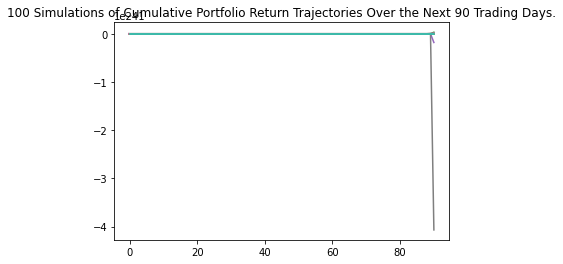

In [171]:
# Plot simulation outcomes
line_plot = MC_1year.plot_simulation()
line_plot.get_figure().savefig("MC_1year_sim_plot.png", bbox_inches="tight")

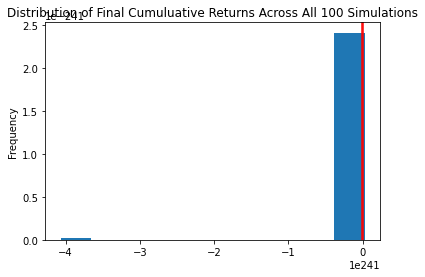

In [172]:
# Plot probability distribution and confidence intervals
dist_plot = MC_1year.plot_distribution()
dist_plot.get_figure().savefig('MC_1year_dist_plot.png',bbox_inches='tight')

In [173]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_1year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count            1.000000e+02
mean           -4.193325e+239
std                       inf
min            -4.068309e+241
25%            -3.159870e+231
50%             1.966690e+221
75%             1.770042e+231
max             3.112184e+239
95% CI Lower   -1.995714e+238
95% CI Upper    6.175767e+238
Name: 90, dtype: float64
